Load in libraries

In [4]:
import pandas as pd
from itertools import takewhile
import plotly.graph_objects as go
import plotly.express as px
import base64
import numpy as np
import glob
import xarray as xr
import matplotlib.pyplot as plt

from fig_mods.getdata import load_ch4
from fig_mods.getdata import load_n2o
from fig_mods.getdata import load_fgas

from fig_mods import path
from fig_mods.nextstep import read_invent_ODS

In [10]:
import cartopy
import cartopy.crs as ccrs

Read in InTEM data

In [5]:
ds_flux = xr.open_dataset("data/flux_data.nc")

In [6]:
## Create a function to produce a mean flux reading for each year;

def weighted_temporal_mean(ds, var):

    month_length = ds_flux.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds_flux[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")
    
    return obs_sum / ones_out

In [7]:
Intem_new_year = weighted_temporal_mean(ds_flux, "flux_prior")
#Intem_new_year

In [8]:
## Set the longitude and latitude to only include the UK;

min_lon = -12
min_lat = 48
max_lon = 5 
max_lat = 62 

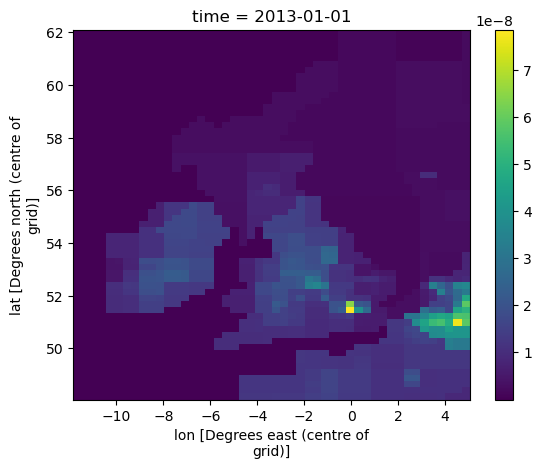

In [56]:
Intem2012 = Intem_new_year[dict(time=0)]
Intem2012 = Intem2012.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

Intem2013 = Intem_new_year[dict(time=1)]
Intem2013 = Intem2013.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

Intem2014 = Intem_new_year[dict(time=2)]
Intem2014 = Intem2014.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

Intem2015 = Intem_new_year[dict(time=3)]
Intem2015 = Intem2015.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

Intem2013
Intem2013.plot()

Read in inventory data

In [10]:
def read_invent_ch4(year, species):
    import pandas as pd
    from itertools import takewhile
    import plotly.graph_objects as go
    import base64
    import numpy as np
    import glob
    import xarray as xr
    
    csv = glob.glob(f"data/ch4-ukghg-{species}_EUROPE_{year}.nc")
    
    flux = xr.open_dataset(csv[0])
    
    min_lon = -12
    min_lat = 48
    max_lon = 5 
    max_lat = 62 
    
    cropped_ds = flux.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
    
    return cropped_ds

In [11]:
total2012 = read_invent_ch4("2012", "total")
agri2012 = read_invent_ch4("2012", "agric")
domcom2012 = read_invent_ch4("2012", "domcom")
energyprod2012 = read_invent_ch4("2012", "energyprod")
indcom2012 = read_invent_ch4("2012", "indcom")
indproc2012 = read_invent_ch4("2012", "indproc")
natural2012 = read_invent_ch4("2012", "natural")
offshore2012 = read_invent_ch4("2012", "offshore")
othertrans2012 = read_invent_ch4("2012", "othertrans")
roadtrans2012 = read_invent_ch4("2012", "roadtrans")
waste2012 = read_invent_ch4("2012", "waste")

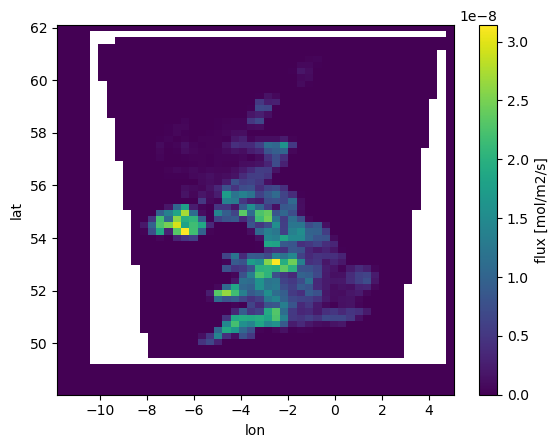

In [18]:
agri2012.flux.plot()

Develop the 'fraction' for each sector based on the inventory data

In [12]:
ag_fraction12 = agri2012.flux / total2012.flux
ag_fraction12 = ag_fraction12.reindex_like(Intem2012, method='nearest', tolerance=0.01)

domcom_fraction12 = domcom2012.flux / total2012.flux
domcom_fraction12 = domcom_fraction12.reindex_like(Intem2012, method='nearest', tolerance=0.01)

eprod_fraction12 = energyprod2012.flux / total2012.flux
eprod_fraction12 = eprod_fraction12.reindex_like(Intem2012, method='nearest', tolerance=0.01)

indcom_fraction12 = indcom2012.flux / total2012.flux
indcom_fraction12 = indcom_fraction12.reindex_like(Intem2012, method='nearest', tolerance=0.01)

indproc_fraction12 = indproc2012.flux / total2012.flux
indproc_fraction12 = indproc_fraction12.reindex_like(Intem2012, method='nearest', tolerance=0.01)

natural_fraction12 = natural2012.flux / total2012.flux
natural_fraction12 = natural_fraction12.reindex_like(Intem2012, method='nearest', tolerance=0.01)

offshore_fraction12 = offshore2012.flux / total2012.flux
offshore_fraction12 = offshore_fraction12.reindex_like(Intem2012, method='nearest', tolerance=0.01)

othertrans_fraction12 = othertrans2012.flux / total2012.flux
othertrans_fraction12 = othertrans_fraction12.reindex_like(Intem2012, method='nearest', tolerance=0.01)

roadtrans_fraction12 = roadtrans2012.flux / total2012.flux
roadtrans_fraction12 = roadtrans_fraction12.reindex_like(Intem2012, method='nearest', tolerance=0.01)

waste_fraction12 = waste2012.flux / total2012.flux
waste_fraction12 = waste_fraction12.reindex_like(Intem2012, method='nearest', tolerance=0.01)

In [13]:
Intem_domcom12 = domcom_fraction12 * Intem2012
Intem_eprod12 = eprod_fraction12 * Intem2012
Intem_indcom12 = indcom_fraction12 * Intem2012
Intem_indproc12 = indproc_fraction12 * Intem2012
Intem_natural12 = natural_fraction12 * Intem2012
Intem_offshore12 = offshore_fraction12 * Intem2012
Intem_othertrans12 = othertrans_fraction12 * Intem2012
Intem_roadtrans12 = roadtrans_fraction12 * Intem2012
Intem_waste12 = waste_fraction12 * Intem2012

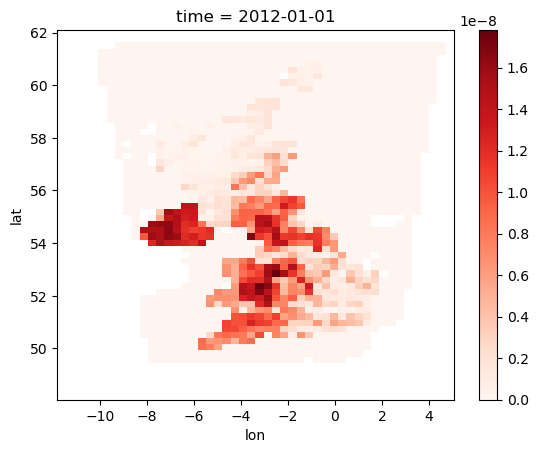

In [14]:
Intem_agri12 = ag_fraction12 * Intem2012
Intem_agri12.plot(cmap=plt.cm.get_cmap('Reds'))

Plot InTEM sector maps (2012)

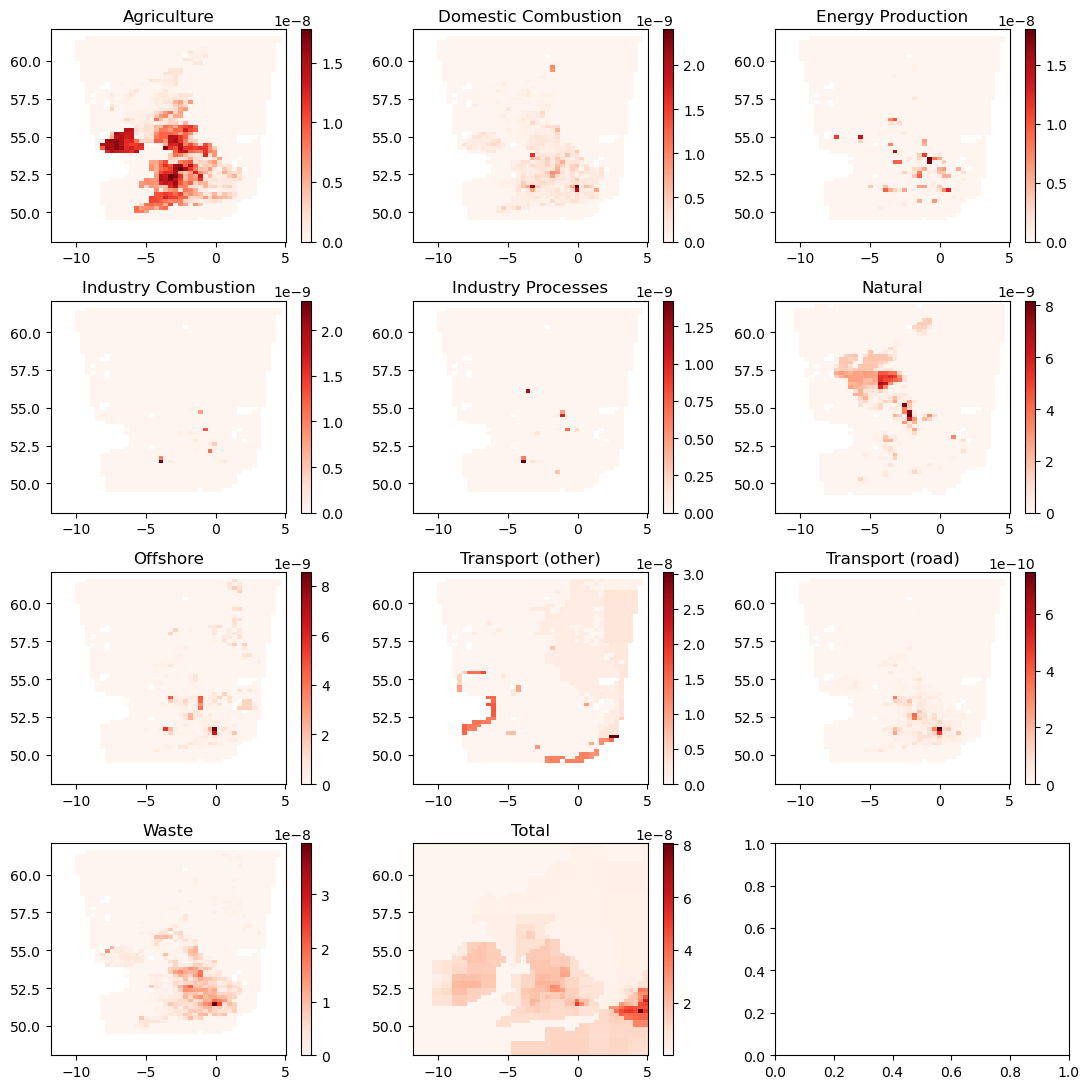

In [15]:
fig, axs = plt.subplots(4, 3, figsize = (11, 11))

ag = axs[0, 0].pcolormesh(Intem_agri12.lon, Intem_agri12.lat, Intem_agri12, cmap=plt.cm.get_cmap('Reds'))
fig.colorbar(ag, ax=axs[0, 0])
axs[0, 0].set_title('Agriculture')

dom = axs[0, 1].pcolormesh(Intem_domcom12.lon, Intem_domcom12.lat, Intem_domcom12, cmap=plt.cm.get_cmap('Reds'))
fig.colorbar(dom, ax=axs[0, 1])
axs[0, 1].set_title('Domestic Combustion')

ep = axs[0, 2].pcolormesh(Intem_eprod12.lon, Intem_eprod12.lat, Intem_eprod12, cmap=plt.cm.get_cmap('Reds'))
fig.colorbar(ep, ax=axs[0, 2])
axs[0, 2].set_title('Energy Production')

ind = axs[1, 0].pcolormesh(Intem_indcom12.lon, Intem_indcom12.lat, Intem_indcom12, cmap=plt.cm.get_cmap('Reds'))
fig.colorbar(ind, ax=axs[1, 0])
axs[1, 0].set_title('Industry Combustion')

iproc = axs[1, 1].pcolormesh(Intem_indproc12.lon, Intem_indproc12.lat, Intem_indproc12, cmap=plt.cm.get_cmap('Reds'))
fig.colorbar(iproc, ax=axs[1, 1])
axs[1, 1].set_title('Industry Processes')

nat = axs[1, 2].pcolormesh(Intem_natural12.lon, Intem_natural12.lat, Intem_natural12, cmap=plt.cm.get_cmap('Reds'))
fig.colorbar(nat, ax=axs[1, 2])
axs[1, 2].set_title('Natural')

off = axs[2, 0].pcolormesh(Intem_offshore12.lon, Intem_offshore12.lat, Intem_offshore12, cmap=plt.cm.get_cmap('Reds'))
fig.colorbar(off, ax=axs[2, 0])
axs[2, 0].set_title('Offshore')

ot = axs[2, 1].pcolormesh(Intem_othertrans12.lon, Intem_othertrans12.lat, Intem_othertrans12, cmap=plt.cm.get_cmap('Reds'))
fig.colorbar(ot, ax=axs[2, 1])
axs[2, 1].set_title('Transport (other)')

rt = axs[2, 2].pcolormesh(Intem_roadtrans12.lon, Intem_roadtrans12.lat, Intem_roadtrans12, cmap=plt.cm.get_cmap('Reds'))
fig.colorbar(rt, ax=axs[2, 2])
axs[2, 2].set_title('Transport (road)')

w = axs[3, 0].pcolormesh(Intem_waste12.lon, Intem_waste12.lat, Intem_waste12, cmap=plt.cm.get_cmap('Reds'))
fig.colorbar(w, ax=axs[3, 0])
axs[3, 0].set_title('Waste')

t = axs[3, 1].pcolormesh(Intem2012.lon, Intem2012.lat, Intem2012, cmap=plt.cm.get_cmap('Reds'))
fig.colorbar(t, ax=axs[3, 1])
axs[3, 1].set_title('Total')

fig.tight_layout()

2013 data

In [15]:
total2013 = read_invent_ch4("2013", "total")
agri2013 = read_invent_ch4("2013", "agric")
domcom2013 = read_invent_ch4("2013", "domcom")
energyprod2013 = read_invent_ch4("2013", "energyprod")
indcom2013 = read_invent_ch4("2013", "indcom")
indproc2013 = read_invent_ch4("2013", "indproc")
natural2013 = read_invent_ch4("2013", "natural")
offshore2013 = read_invent_ch4("2013", "offshore")
othertrans2013 = read_invent_ch4("2013", "othertrans")
roadtrans2013 = read_invent_ch4("2013", "roadtrans")
waste2013 = read_invent_ch4("2013", "waste")

In [16]:
ag_fraction13 = agri2013.flux / total2013.flux
ag_fraction13 = ag_fraction13.reindex_like(Intem2013, method='nearest', tolerance=0.01)

domcom_fraction13 = domcom2013.flux / total2013.flux
domcom_fraction13 = domcom_fraction13.reindex_like(Intem2013, method='nearest', tolerance=0.01)

eprod_fraction13 = energyprod2013.flux / total2013.flux
eprod_fraction13 = eprod_fraction13.reindex_like(Intem2013, method='nearest', tolerance=0.01)

indcom_fraction13 = indcom2013.flux / total2013.flux
indcom_fraction13 = indcom_fraction13.reindex_like(Intem2013, method='nearest', tolerance=0.01)

indproc_fraction13 = indproc2013.flux / total2013.flux
indproc_fraction13 = indproc_fraction13.reindex_like(Intem2013, method='nearest', tolerance=0.01)

natural_fraction13 = natural2013.flux / total2013.flux
natural_fraction13 = natural_fraction13.reindex_like(Intem2013, method='nearest', tolerance=0.01)

offshore_fraction13 = offshore2013.flux / total2013.flux
offshore_fraction13 = offshore_fraction13.reindex_like(Intem2013, method='nearest', tolerance=0.01)

othertrans_fraction13 = othertrans2013.flux / total2013.flux
othertrans_fraction13 = othertrans_fraction13.reindex_like(Intem2013, method='nearest', tolerance=0.01)

roadtrans_fraction13 = roadtrans2013.flux / total2013.flux
roadtrans_fraction13 = roadtrans_fraction13.reindex_like(Intem2013, method='nearest', tolerance=0.01)

waste_fraction13 = waste2013.flux / total2013.flux
waste_fraction13 = waste_fraction13.reindex_like(Intem2013, method='nearest', tolerance=0.01)

In [17]:
Intem_agri13 = ag_fraction13 * Intem2013
Intem_domcom13 = domcom_fraction13 * Intem2013
Intem_eprod13 = eprod_fraction13 * Intem2013
Intem_indcom13 = indcom_fraction13 * Intem2013
Intem_indproc13 = indproc_fraction13 * Intem2013
Intem_natural13 = natural_fraction13 * Intem2013
Intem_offshore13 = offshore_fraction13 * Intem2013
Intem_othertrans13 = othertrans_fraction13 * Intem2013
Intem_roadtrans13 = roadtrans_fraction13 * Intem2013
Intem_waste13 = waste_fraction13 * Intem2013

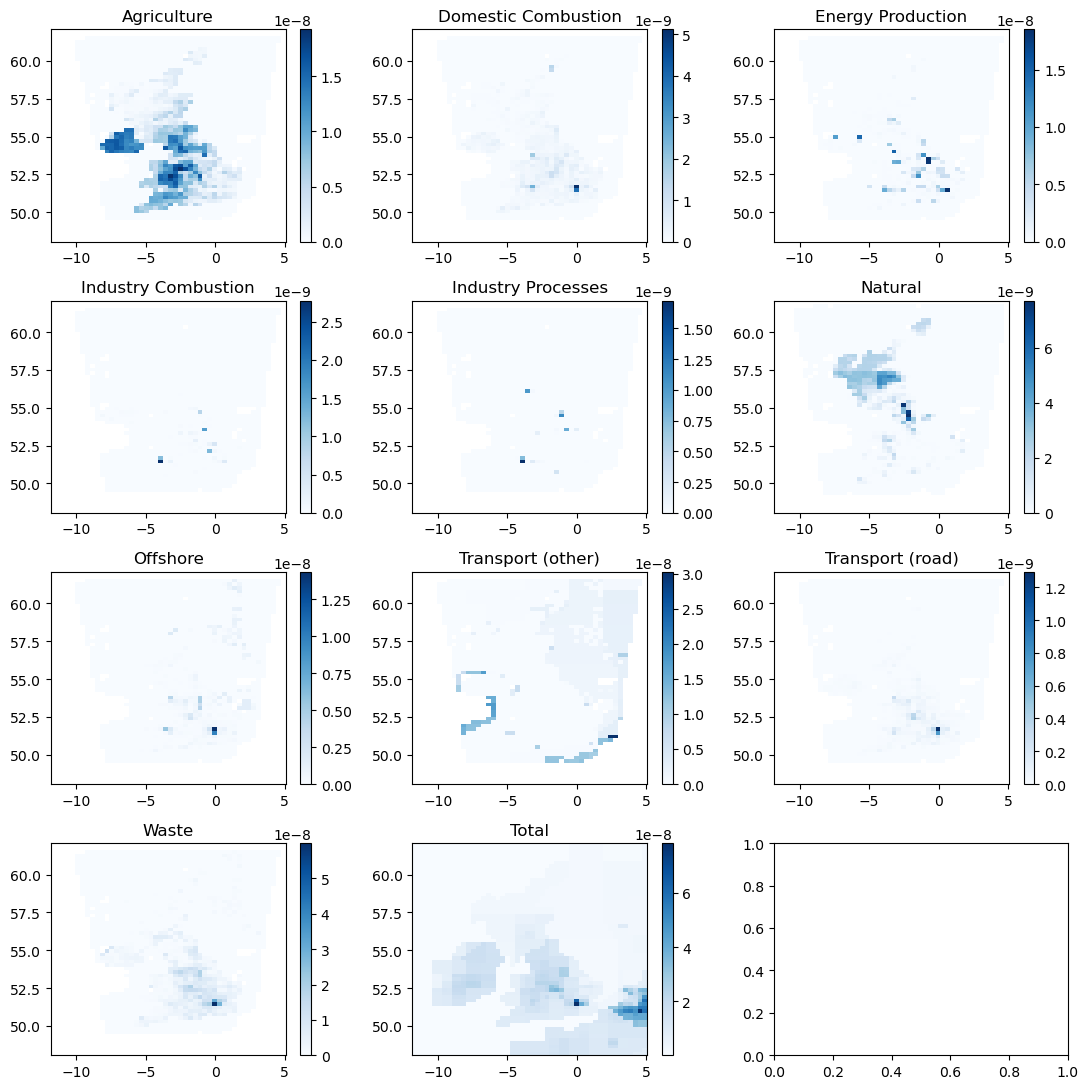

In [41]:
fig1, axs = plt.subplots(4, 3, figsize = (11, 11))

ag1 = axs[0, 0].pcolormesh(Intem_agri13.lon, Intem_agri13.lat, Intem_agri13, cmap=plt.cm.get_cmap('Blues'))
fig1.colorbar(ag1, ax=axs[0, 0])
axs[0, 0].set_title('Agriculture')

dom1 = axs[0, 1].pcolormesh(Intem_domcom13.lon, Intem_domcom13.lat, Intem_domcom13, cmap=plt.cm.get_cmap('Blues'))
fig1.colorbar(dom1, ax=axs[0, 1])
axs[0, 1].set_title('Domestic Combustion')

ep1 = axs[0, 2].pcolormesh(Intem_eprod13.lon, Intem_eprod13.lat, Intem_eprod13, cmap=plt.cm.get_cmap('Blues'))
fig1.colorbar(ep1, ax=axs[0, 2])
axs[0, 2].set_title('Energy Production')

ind1 = axs[1, 0].pcolormesh(Intem_indcom13.lon, Intem_indcom13.lat, Intem_indcom13, cmap=plt.cm.get_cmap('Blues'))
fig1.colorbar(ind1, ax=axs[1, 0])
axs[1, 0].set_title('Industry Combustion')

iproc1 = axs[1, 1].pcolormesh(Intem_indproc13.lon, Intem_indproc13.lat, Intem_indproc13, cmap=plt.cm.get_cmap('Blues'))
fig1.colorbar(iproc1, ax=axs[1, 1])
axs[1, 1].set_title('Industry Processes')

nat1 = axs[1, 2].pcolormesh(Intem_natural13.lon, Intem_natural13.lat, Intem_natural13, cmap=plt.cm.get_cmap('Blues'))
fig1.colorbar(nat1, ax=axs[1, 2])
axs[1, 2].set_title('Natural')

off1 = axs[2, 0].pcolormesh(Intem_offshore13.lon, Intem_offshore13.lat, Intem_offshore13, cmap=plt.cm.get_cmap('Blues'))
fig1.colorbar(off1, ax=axs[2, 0])
axs[2, 0].set_title('Offshore')

ot1 = axs[2, 1].pcolormesh(Intem_othertrans13.lon, Intem_othertrans13.lat, Intem_othertrans13, cmap=plt.cm.get_cmap('Blues'))
fig1.colorbar(ot1, ax=axs[2, 1])
axs[2, 1].set_title('Transport (other)')

rt1 = axs[2, 2].pcolormesh(Intem_roadtrans13.lon, Intem_roadtrans13.lat, Intem_roadtrans13, cmap=plt.cm.get_cmap('Blues'))
fig1.colorbar(rt1, ax=axs[2, 2])
axs[2, 2].set_title('Transport (road)')

w1 = axs[3, 0].pcolormesh(Intem_waste13.lon, Intem_waste13.lat, Intem_waste13, cmap=plt.cm.get_cmap('Blues'))
fig1.colorbar(w1, ax=axs[3, 0])
axs[3, 0].set_title('Waste')

t1 = axs[3, 1].pcolormesh(Intem2013.lon, Intem2013.lat, Intem2013, cmap=plt.cm.get_cmap('Blues'))
fig1.colorbar(t1, ax=axs[3, 1])
axs[3, 1].set_title('Total')

fig1.tight_layout()

2014 data

In [24]:
total2014 = read_invent_ch4("2014", "total")
agri2014 = read_invent_ch4("2014", "agric")
domcom2014 = read_invent_ch4("2014", "domcom")
energyprod2014 = read_invent_ch4("2014", "energyprod")
indcom2014 = read_invent_ch4("2014", "indcom")
indproc2014 = read_invent_ch4("2014", "indproc")
natural2014 = read_invent_ch4("2014", "natural")
offshore2014 = read_invent_ch4("2014", "offshore")
othertrans2014 = read_invent_ch4("2014", "othertrans")
roadtrans2014 = read_invent_ch4("2014", "roadtrans")
waste2014 = read_invent_ch4("2014", "waste")

In [26]:
ag_fraction14 = agri2014.flux / total2014.flux
ag_fraction14 = ag_fraction14.reindex_like(Intem2014, method='nearest', tolerance=0.01)

domcom_fraction14 = domcom2014.flux / total2014.flux
domcom_fraction14 = domcom_fraction14.reindex_like(Intem2014, method='nearest', tolerance=0.01)

eprod_fraction14 = energyprod2014.flux / total2014.flux
eprod_fraction14 = eprod_fraction14.reindex_like(Intem2014, method='nearest', tolerance=0.01)

indcom_fraction14 = indcom2014.flux / total2014.flux
indcom_fraction14 = indcom_fraction14.reindex_like(Intem2014, method='nearest', tolerance=0.01)

indproc_fraction14 = indproc2014.flux / total2014.flux
indproc_fraction14 = indproc_fraction14.reindex_like(Intem2014, method='nearest', tolerance=0.01)

natural_fraction14 = natural2014.flux / total2014.flux
natural_fraction14 = natural_fraction14.reindex_like(Intem2014, method='nearest', tolerance=0.01)

offshore_fraction14 = offshore2014.flux / total2014.flux
offshore_fraction14 = offshore_fraction14.reindex_like(Intem2014, method='nearest', tolerance=0.01)

othertrans_fraction14 = othertrans2014.flux / total2014.flux
othertrans_fraction14 = othertrans_fraction14.reindex_like(Intem2014, method='nearest', tolerance=0.01)

roadtrans_fraction14 = roadtrans2014.flux / total2014.flux
roadtrans_fraction14 = roadtrans_fraction14.reindex_like(Intem2014, method='nearest', tolerance=0.01)

waste_fraction14 = waste2014.flux / total2014.flux
waste_fraction14 = waste_fraction14.reindex_like(Intem2014, method='nearest', tolerance=0.01)

In [27]:
Intem_agri14 = ag_fraction14 * Intem2014
Intem_domcom14 = domcom_fraction14 * Intem2014
Intem_eprod14 = eprod_fraction14 * Intem2014
Intem_indcom14 = indcom_fraction14 * Intem2014
Intem_indproc14 = indproc_fraction14 * Intem2014
Intem_natural14 = natural_fraction14 * Intem2014
Intem_offshore14 = offshore_fraction14 * Intem2014
Intem_othertrans14 = othertrans_fraction14 * Intem2014
Intem_roadtrans14 = roadtrans_fraction14 * Intem2014
Intem_waste14 = waste_fraction14 * Intem2014

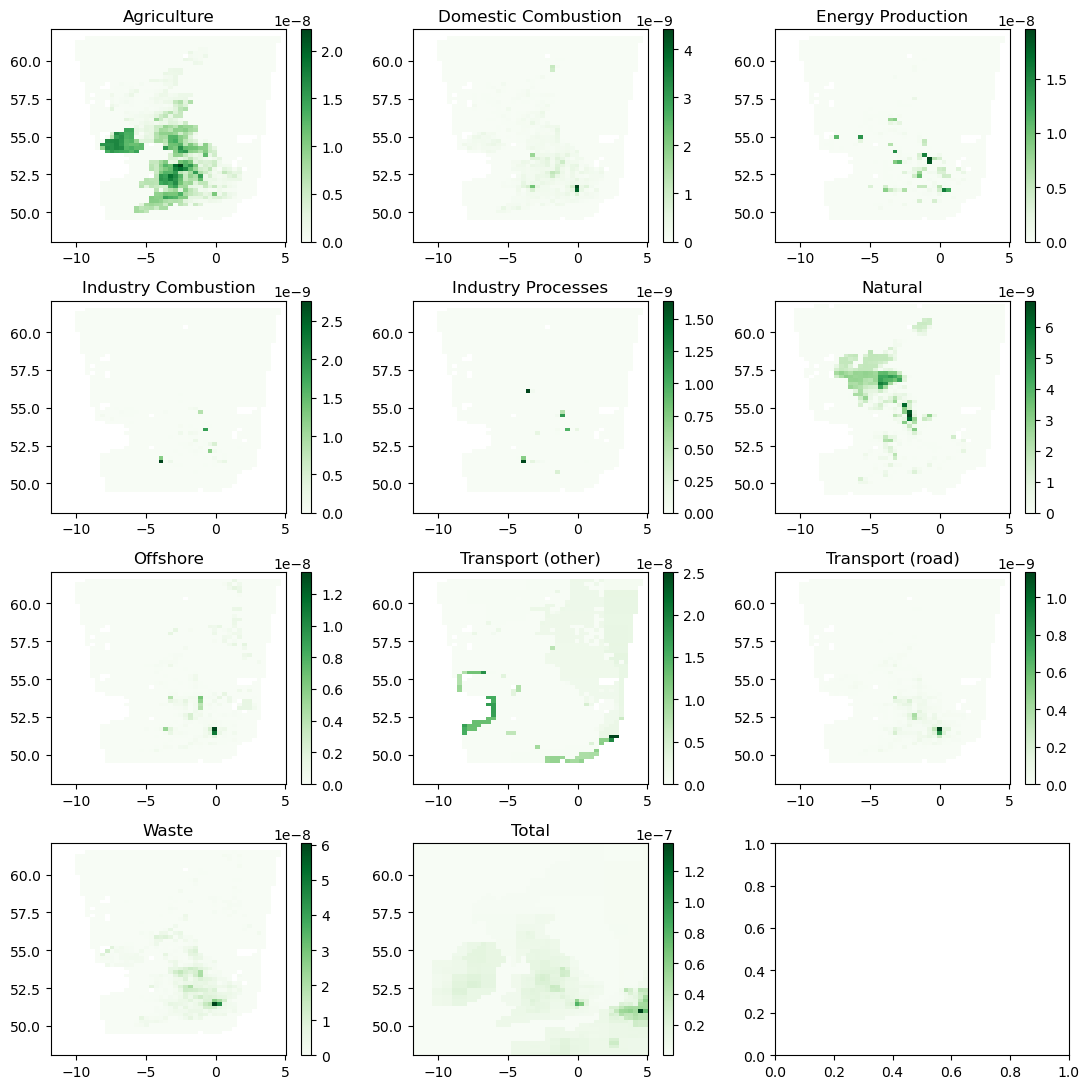

In [42]:
fig2, axs = plt.subplots(4, 3, figsize = (11, 11))

ag2 = axs[0, 0].pcolormesh(Intem_agri14.lon, Intem_agri14.lat, Intem_agri14, cmap=plt.cm.get_cmap('Greens'))
fig2.colorbar(ag2, ax=axs[0, 0])
axs[0, 0].set_title('Agriculture')

dom2 = axs[0, 1].pcolormesh(Intem_domcom14.lon, Intem_domcom14.lat, Intem_domcom14, cmap=plt.cm.get_cmap('Greens'))
fig2.colorbar(dom2, ax=axs[0, 1])
axs[0, 1].set_title('Domestic Combustion')

ep2 = axs[0, 2].pcolormesh(Intem_eprod14.lon, Intem_eprod14.lat, Intem_eprod14, cmap=plt.cm.get_cmap('Greens'))
fig2.colorbar(ep2, ax=axs[0, 2])
axs[0, 2].set_title('Energy Production')

ind2 = axs[1, 0].pcolormesh(Intem_indcom14.lon, Intem_indcom14.lat, Intem_indcom14, cmap=plt.cm.get_cmap('Greens'))
fig2.colorbar(ind2, ax=axs[1, 0])
axs[1, 0].set_title('Industry Combustion')

iproc2 = axs[1, 1].pcolormesh(Intem_indproc14.lon, Intem_indproc14.lat, Intem_indproc14, cmap=plt.cm.get_cmap('Greens'))
fig2.colorbar(iproc2, ax=axs[1, 1])
axs[1, 1].set_title('Industry Processes')

nat2 = axs[1, 2].pcolormesh(Intem_natural14.lon, Intem_natural14.lat, Intem_natural14, cmap=plt.cm.get_cmap('Greens'))
fig2.colorbar(nat2, ax=axs[1, 2])
axs[1, 2].set_title('Natural')

off2 = axs[2, 0].pcolormesh(Intem_offshore14.lon, Intem_offshore14.lat, Intem_offshore14, cmap=plt.cm.get_cmap('Greens'))
fig2.colorbar(off2, ax=axs[2, 0])
axs[2, 0].set_title('Offshore')

ot2 = axs[2, 1].pcolormesh(Intem_othertrans14.lon, Intem_othertrans14.lat, Intem_othertrans14, cmap=plt.cm.get_cmap('Greens'))
fig2.colorbar(ot2, ax=axs[2, 1])
axs[2, 1].set_title('Transport (other)')

rt2 = axs[2, 2].pcolormesh(Intem_roadtrans14.lon, Intem_roadtrans14.lat, Intem_roadtrans14, cmap=plt.cm.get_cmap('Greens'))
fig2.colorbar(rt2, ax=axs[2, 2])
axs[2, 2].set_title('Transport (road)')

w2 = axs[3, 0].pcolormesh(Intem_waste14.lon, Intem_waste14.lat, Intem_waste14, cmap=plt.cm.get_cmap('Greens'))
fig2.colorbar(w2, ax=axs[3, 0])
axs[3, 0].set_title('Waste')

t2 = axs[3, 1].pcolormesh(Intem2014.lon, Intem2014.lat, Intem2014, cmap=plt.cm.get_cmap('Greens'))
fig2.colorbar(t2, ax=axs[3, 1])
axs[3, 1].set_title('Total')

fig2.tight_layout()

2015 data

In [30]:
total2015 = read_invent_ch4("2015", "total")
agri2015 = read_invent_ch4("2015", "agric")
domcom2015 = read_invent_ch4("2015", "domcom")
energyprod2015 = read_invent_ch4("2015", "energyprod")
indcom2015 = read_invent_ch4("2015", "indcom")
indproc2015 = read_invent_ch4("2015", "indproc")
natural2015 = read_invent_ch4("2015", "natural")
offshore2015 = read_invent_ch4("2015", "offshore")
othertrans2015 = read_invent_ch4("2015", "othertrans")
roadtrans2015 = read_invent_ch4("2015", "roadtrans")
waste2015 = read_invent_ch4("2015", "waste")

In [33]:
ag_fraction15 = agri2015.flux / total2015.flux
ag_fraction15 = ag_fraction15.reindex_like(Intem2015, method='nearest', tolerance=0.01)

domcom_fraction15 = domcom2015.flux / total2015.flux
domcom_fraction15 = domcom_fraction15.reindex_like(Intem2015, method='nearest', tolerance=0.01)

eprod_fraction15 = energyprod2015.flux / total2015.flux
eprod_fraction15 = eprod_fraction15.reindex_like(Intem2015, method='nearest', tolerance=0.01)

indcom_fraction15 = indcom2015.flux / total2015.flux
indcom_fraction15 = indcom_fraction15.reindex_like(Intem2015, method='nearest', tolerance=0.01)

indproc_fraction15 = indproc2015.flux / total2015.flux
indproc_fraction15 = indproc_fraction15.reindex_like(Intem2015, method='nearest', tolerance=0.01)

natural_fraction15 = natural2015.flux / total2015.flux
natural_fraction15 = natural_fraction15.reindex_like(Intem2015, method='nearest', tolerance=0.01)

offshore_fraction15 = offshore2015.flux / total2015.flux
offshore_fraction15 = offshore_fraction15.reindex_like(Intem2015, method='nearest', tolerance=0.01)

othertrans_fraction15 = othertrans2015.flux / total2015.flux
othertrans_fraction15 = othertrans_fraction15.reindex_like(Intem2015, method='nearest', tolerance=0.01)

roadtrans_fraction15 = roadtrans2015.flux / total2015.flux
roadtrans_fraction15 = roadtrans_fraction15.reindex_like(Intem2015, method='nearest', tolerance=0.01)

waste_fraction15 = waste2015.flux / total2015.flux
waste_fraction15 = waste_fraction15.reindex_like(Intem2015, method='nearest', tolerance=0.01)

In [34]:
Intem_agri15 = ag_fraction15 * Intem2015
Intem_domcom15 = domcom_fraction15 * Intem2015
Intem_eprod15 = eprod_fraction15 * Intem2015
Intem_indcom15 = indcom_fraction15 * Intem2015
Intem_indproc15 = indproc_fraction15 * Intem2015
Intem_natural15 = natural_fraction15 * Intem2015
Intem_offshore15 = offshore_fraction15 * Intem2015
Intem_othertrans15 = othertrans_fraction15 * Intem2015
Intem_roadtrans15 = roadtrans_fraction15 * Intem2015
Intem_waste15 = waste_fraction15 * Intem2015

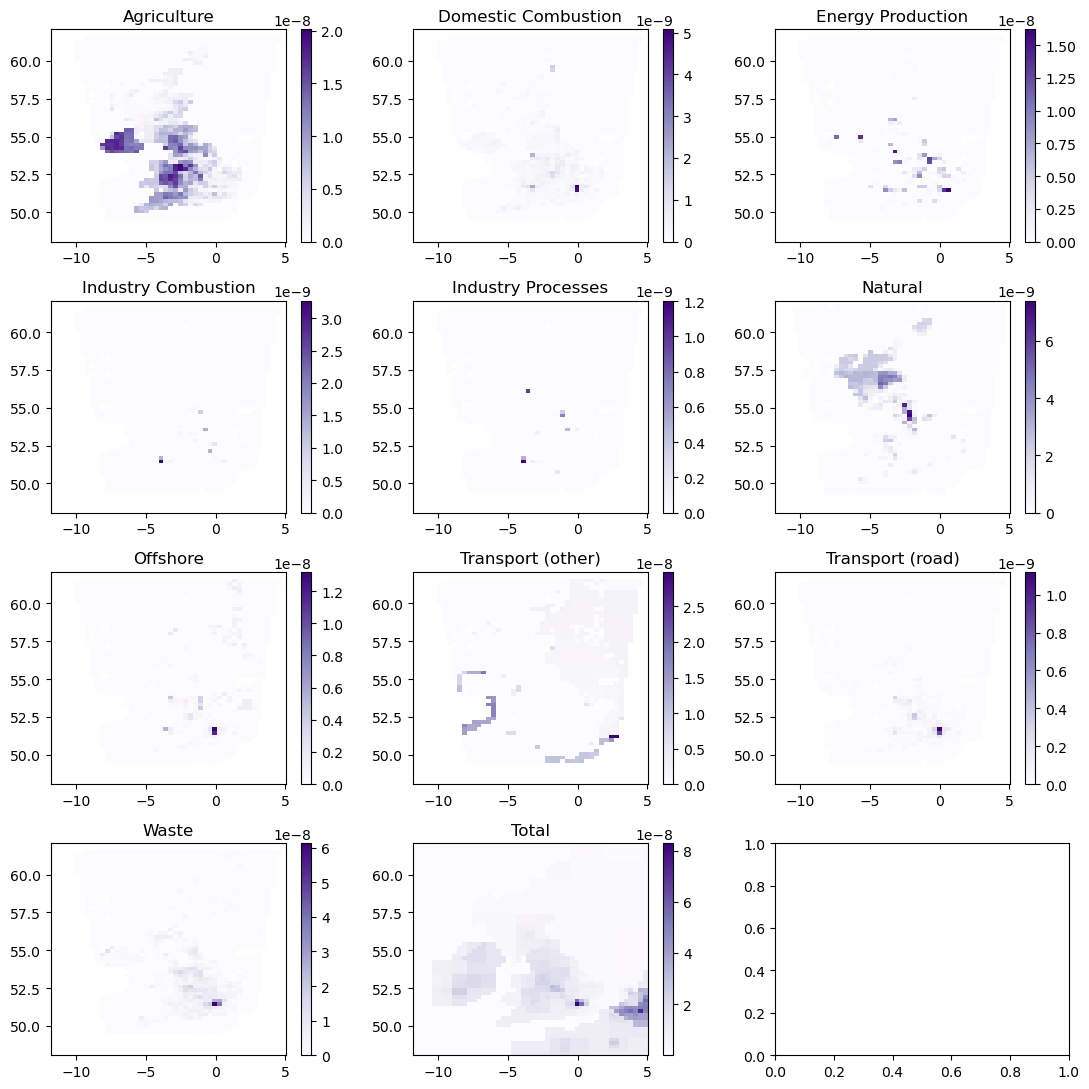

In [43]:
fig3, axs = plt.subplots(4, 3, figsize = (11, 11))

ag3 = axs[0, 0].pcolormesh(Intem_agri15.lon, Intem_agri15.lat, Intem_agri15, cmap=plt.cm.get_cmap('Purples'))
fig3.colorbar(ag3, ax=axs[0, 0])
axs[0, 0].set_title('Agriculture')

dom3 = axs[0, 1].pcolormesh(Intem_domcom15.lon, Intem_domcom15.lat, Intem_domcom15, cmap=plt.cm.get_cmap('Purples'))
fig3.colorbar(dom3, ax=axs[0, 1])
axs[0, 1].set_title('Domestic Combustion')

ep3 = axs[0, 2].pcolormesh(Intem_eprod15.lon, Intem_eprod15.lat, Intem_eprod15, cmap=plt.cm.get_cmap('Purples'))
fig3.colorbar(ep3, ax=axs[0, 2])
axs[0, 2].set_title('Energy Production')

ind3 = axs[1, 0].pcolormesh(Intem_indcom15.lon, Intem_indcom15.lat, Intem_indcom15, cmap=plt.cm.get_cmap('Purples'))
fig3.colorbar(ind3, ax=axs[1, 0])
axs[1, 0].set_title('Industry Combustion')

iproc3 = axs[1, 1].pcolormesh(Intem_indproc15.lon, Intem_indproc15.lat, Intem_indproc15, cmap=plt.cm.get_cmap('Purples'))
fig3.colorbar(iproc3, ax=axs[1, 1])
axs[1, 1].set_title('Industry Processes')

nat3 = axs[1, 2].pcolormesh(Intem_natural15.lon, Intem_natural15.lat, Intem_natural15, cmap=plt.cm.get_cmap('Purples'))
fig3.colorbar(nat3, ax=axs[1, 2])
axs[1, 2].set_title('Natural')

off3 = axs[2, 0].pcolormesh(Intem_offshore15.lon, Intem_offshore15.lat, Intem_offshore15, cmap=plt.cm.get_cmap('Purples'))
fig3.colorbar(off3, ax=axs[2, 0])
axs[2, 0].set_title('Offshore')

ot3 = axs[2, 1].pcolormesh(Intem_othertrans15.lon, Intem_othertrans15.lat, Intem_othertrans15, cmap=plt.cm.get_cmap('Purples'))
fig3.colorbar(ot3, ax=axs[2, 1])
axs[2, 1].set_title('Transport (other)')

rt3 = axs[2, 2].pcolormesh(Intem_roadtrans15.lon, Intem_roadtrans15.lat, Intem_roadtrans15, cmap=plt.cm.get_cmap('Purples'))
fig3.colorbar(rt3, ax=axs[2, 2])
axs[2, 2].set_title('Transport (road)')

w3 = axs[3, 0].pcolormesh(Intem_waste15.lon, Intem_waste15.lat, Intem_waste15, cmap=plt.cm.get_cmap('Purples'))
fig3.colorbar(w3, ax=axs[3, 0])
axs[3, 0].set_title('Waste')

t3 = axs[3, 1].pcolormesh(Intem2015.lon, Intem2015.lat, Intem2015, cmap=plt.cm.get_cmap('Purples'))
fig3.colorbar(t3, ax=axs[3, 1])
axs[3, 1].set_title('Total')

fig3.tight_layout()

Plotly

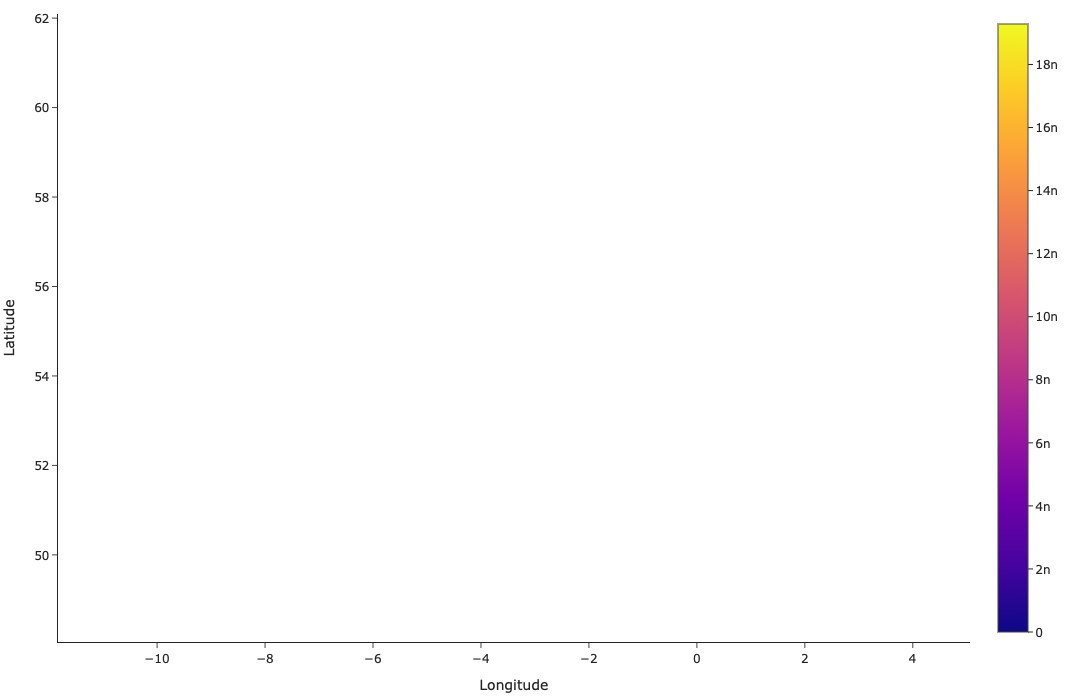

In [23]:
fig = px.imshow(Intem_agri13, origin='lower')
fig.update_layout(margin={"r":55,"t":10,"l":10,"b":40}, 
    autosize = True,
    template = "simple_white",
    width=1000, height=700,
    yaxis_title = "Latitude",
    xaxis_title = "Longitude",
    showlegend=False)
fig.show()

In [43]:
fig = px.imshow(Intem_agri2012*ag_fraction12, origin='lower')
fig.update_layout(margin={"r":55,"t":10,"l":10,"b":40}, 
    autosize = True,
    template = "simple_white",
    width=1000, height=700,
    yaxis_title = "Latitude",
    xaxis_title = "Longitude",
    showlegend=False)
fig.show()

NameError: name 'Intem_agri2012' is not defined

Modulised

In [16]:
def intem_sector_fraction(year, species):
        
    a = read_invent_ch4(year, species)
    b = read_invent_ch4(year, "total")
    
    df = a.flux / b.flux
    df = df.reindex_like(Intem2012, method='nearest', tolerance=0.01)
    
    if year == "2012":
        df = df * Intem2012
    elif year == "2013":
        df = df * Intem2013
    elif year == "2014":
        df = df * Intem2014
    elif year == "2015":
        df = df * Intem2015
        
    return df

In [17]:
intem_sector_fraction("2013", "agric")

<xarray.DataArray (lat: 60, lon: 48)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  0.,  0., nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -11.66 -11.31 -10.96 -10.6 ... 3.828 4.18 4.532 4.884
  * lat      (lat) float64 48.17 48.4 48.64 48.87 ... 61.27 61.51 61.74 61.98
    time     datetime64[ns] 2013-01-01

In [18]:
def plot_intem(year):
    
    a = intem_sector_fraction(year, "agric")
    b = intem_sector_fraction(year, "domcom")
    c = intem_sector_fraction(year, "energyprod")
    d = intem_sector_fraction(year, "indcom")
    
    if year == "2012":
        x = "Reds"
    elif year == "2013":
        x = "Blues"
    elif year == "2014":
        x = "Greens"
    elif year == "2015":
        x = "Purples"
    
    fig, axs = plt.subplots(2, 2, figsize = (11, 11))
    
    ag = axs[0, 0].pcolormesh(a.lon, a.lat, a, cmap=plt.cm.get_cmap(x))
    fig.colorbar(ag, ax=axs[0, 0])
    axs[0, 0].set_title('Agriculture')
    
    dom = axs[0, 1].pcolormesh(b.lon, b.lat, b, cmap=plt.cm.get_cmap(x))
    fig.colorbar(dom, ax=axs[0, 1])
    axs[0, 1].set_title('Domestic Combustion')
    
    ep = axs[1, 0].pcolormesh(c.lon, c.lat, c, cmap=plt.cm.get_cmap(x))
    fig.colorbar(ep, ax=axs[1, 0])
    axs[1, 0].set_title('Energy Production')
    
    ind = axs[1, 1].pcolormesh(d.lon, d.lat, d, cmap=plt.cm.get_cmap(x))
    fig.colorbar(ind, ax=axs[1, 1])
    axs[1, 1].set_title('Industry Combustion')
    
    fig.tight_layout()

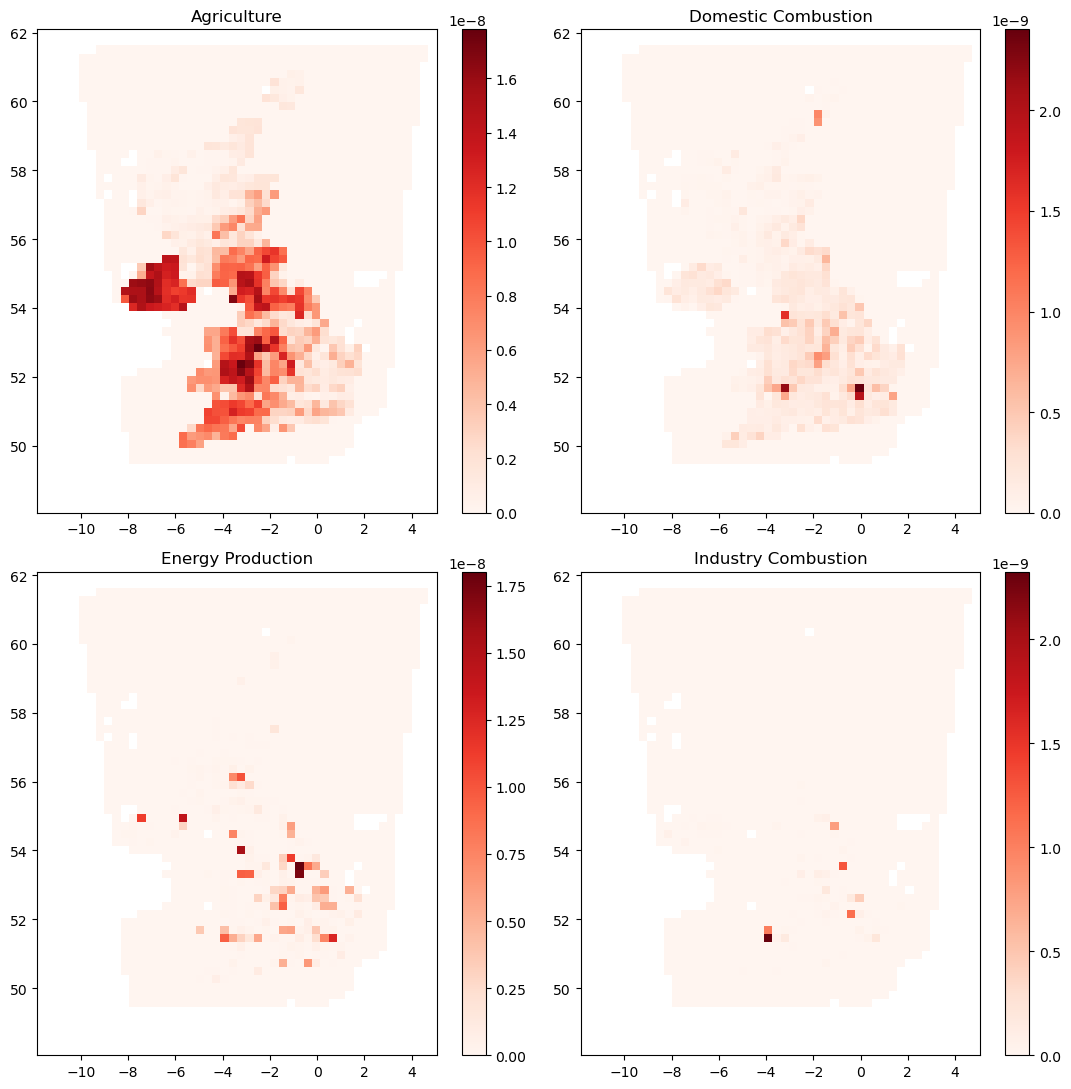

In [19]:
plot_intem("2012")

Cartopy

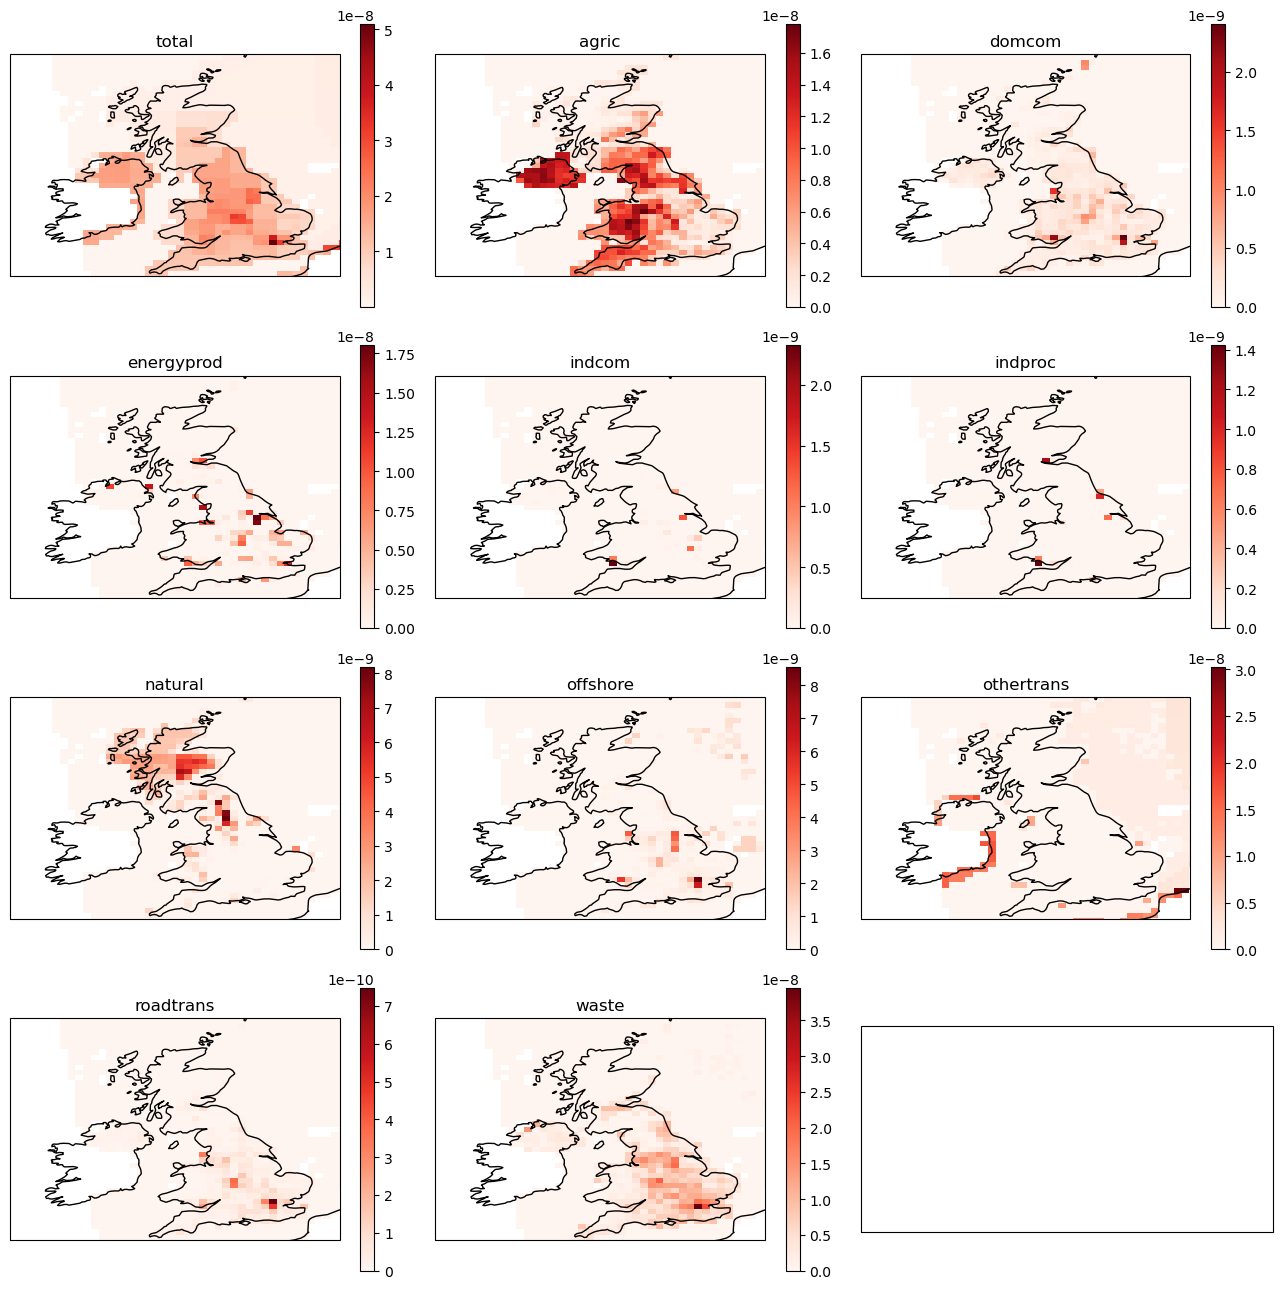

In [75]:
fig, axs = plt.subplots(4, 3, figsize = (13, 13), subplot_kw={'projection':cartopy.crs.PlateCarree()})

species = ["total", "agric", "domcom", "energyprod", "indcom", "indproc", "natural", "offshore", "othertrans", "roadtrans", "waste"]

for name, ax in zip(species, axs.flatten()):
    
    a = read_invent_ch4("2012", name)
    b = read_invent_ch4("2012", "total")
    
    fract = a.flux / b.flux
    test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)
    
    data = test * Intem2012
    
    a = ax.pcolormesh(data.lon, data.lat, data, cmap=plt.cm.get_cmap('Reds'))
    ax.set_extent([-12,3, 49.9,60], crs=cartopy.crs.PlateCarree())        
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.set_title(name)
    fig.colorbar(a, ax=ax)

fig.tight_layout()


In [3]:
cartopy.__version__

'0.20.2'